In [ ]:
import numpy as np


def calculate_phase_mismatch(wavelength1, wavelength2, t):
    params = {
        "no": {  # 通常光線 (ordinary ray)
            "a": [4.508200, 0.084888, 0.195520, 1.157000, 8.251700, 0.023700],
            "b": [2.070400e-08, 1.444900e-08, 1.597800e-08, 4.768600e-06, 1.112700e-05],
        },
        "ne": {  # 異常光線 (extraordinary ray)
            "a": [4.561500, 0.084880, 0.192700, 5.583200, 8.306700, 0.021696],
            "b": [4.782000e-07, 3.091300e-08, 2.732600e-08, 1.483700e-05, 1.364700e-07],
        },
    }["ne"]

    def _n_eff(wavelength, t):
        """セルマイヤーの分散式を用いて実効屈折率を計算"""
        f = (t - 24.5) * (t + 24.5 + 2 * 273.16)
        lambda_sq = wavelength**2
        a = params["a"]
        b = params["b"]
        n_sq = (
            a[0]
            + b[0] * f
            + (a[1] + b[1] * f) / (lambda_sq - (a[2] + b[2] * f) ** 2)
            + (a[3] + b[3] * f) / (lambda_sq - (a[4] + b[4] * f) ** 2)
            - a[5] * lambda_sq
        )
        return np.sqrt(n_sq)

    wavelength_sum = (wavelength1 * wavelength2) / (wavelength1 + wavelength2)

    # 屈折率
    n1 = _n_eff(wavelength1, t)
    n2 = _n_eff(wavelength2, t)
    n_sum = _n_eff(wavelength_sum, t)

    beta1 = 2 * np.pi * n1 / wavelength1
    beta2 = 2 * np.pi * n2 / wavelength2
    beta_sum = 2 * np.pi * n_sum / wavelength_sum

    phase_mismatch = beta_sum - (beta1 + beta2)

    print(
        f"Wavelengths: {wavelength1:.4f} µm + {wavelength2:.4f} µm -> {wavelength_sum:.4f} µm"
    )
    print(f"Refractive Indices: n1={n1:.4f}, n2={n2:.4f}, n_sum={n_sum:.4f}")
    print(f"Phase mismatch: {phase_mismatch:.4f} rad/µm\n")
    return phase_mismatch


temp = 70  # °C

print("--- SHG 計算 (1.031µm -> 1.031/2 µm) ---")
shg_wavelength = 1.031
calculate_phase_mismatch(shg_wavelength, shg_wavelength, temp)

# 2. THG (SFGとして計算): 1.031µm + 0.5155µm -> 0.3437µm (1.031µm / 3)
print("--- THG 計算 (1.031µm + 1.031/2 µm -> 1.031/3 µm) ---")
fundamental_wavelength = 1.031
shg_wavelength_output = fundamental_wavelength / 2
calculate_phase_mismatch(fundamental_wavelength, shg_wavelength_output, temp)

--- SHG 計算 (1.031µm -> 1.031/2 µm) ---
Wavelengths: 1.0310 µm + 1.0310 µm -> 0.5155 µm
Refractive Indices: n1=2.1325, n2=2.1325, n_sum=2.2041
Phase mismatch: 0.8725 rad/µm

--- THG 計算 (1.031µm + 1.031/2 µm -> 1.031/3 µm) ---
Wavelengths: 1.0310 µm + 0.5155 µm -> 0.3437 µm
Refractive Indices: n1=2.1325, n2=2.2041, n_sum=2.3556
Phase mismatch: 3.2071 rad/µm



np.float64(3.2071481894070857)

KAPPA_MAG: 0.000693 (変換効率から逆算)
Simulation time for ケース1: SHG用QPM ($\Lambda$=7.2 $\mu$m): 1.76 seconds
Simulation time for ケース2: SFG用QPM ($\Lambda$≈1.96 $\mu$m): 0.28 seconds


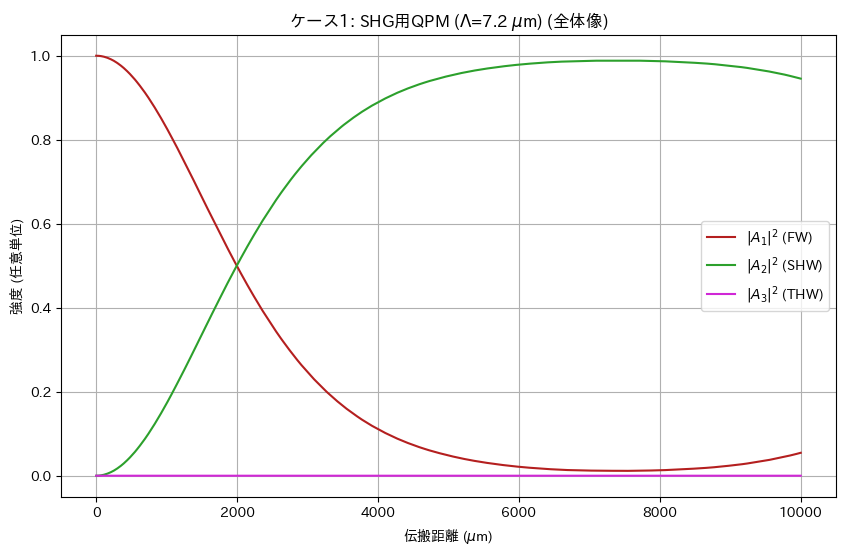

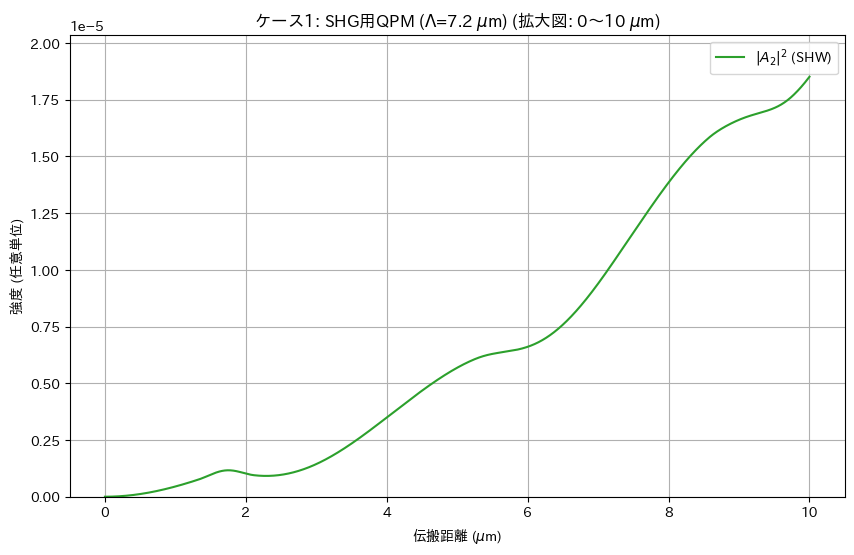

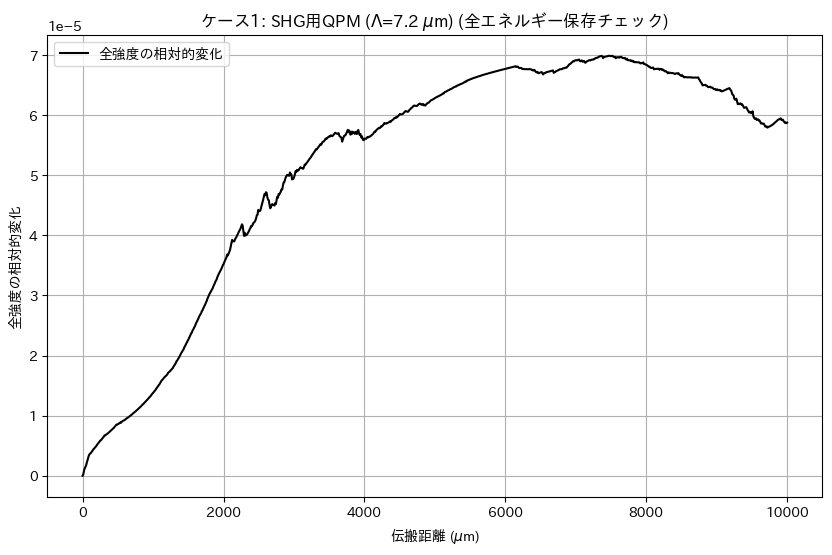

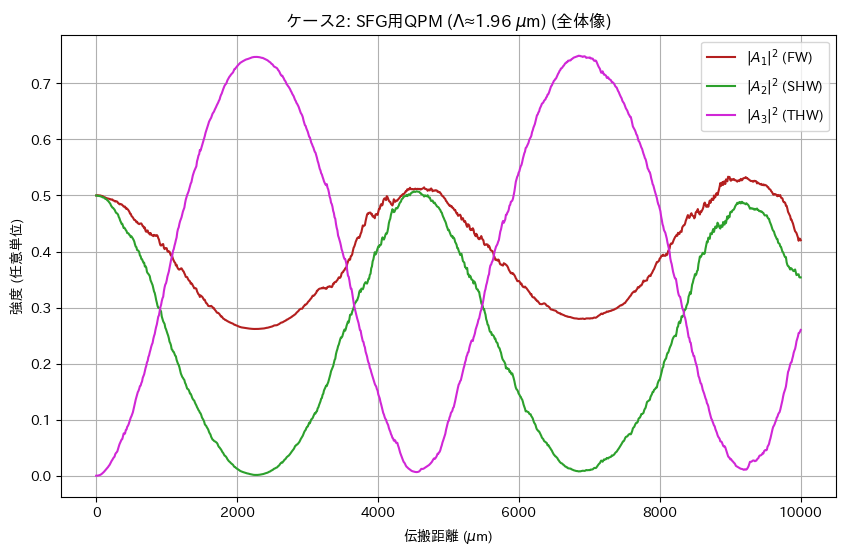

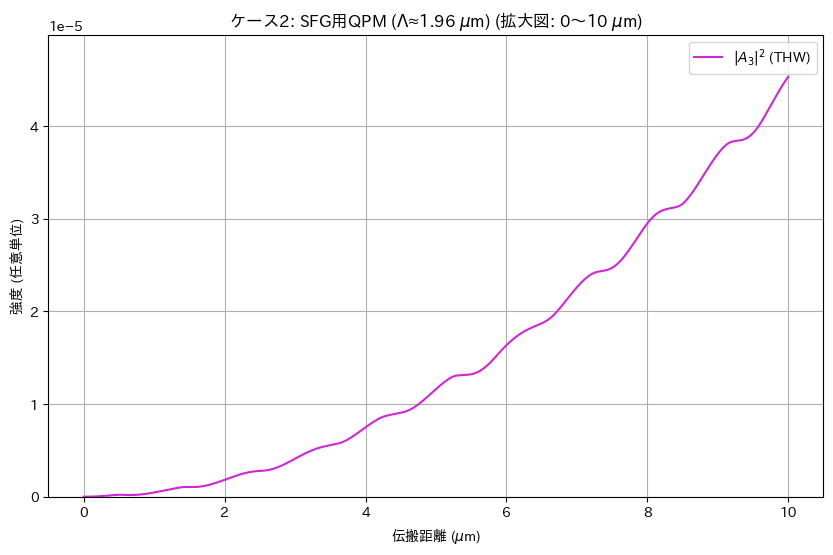

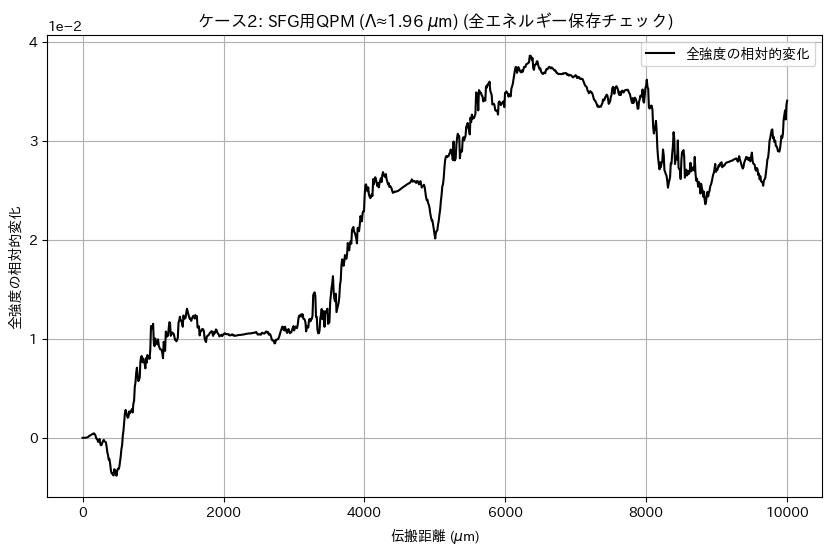

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import japanize_matplotlib
import time


def coupled_odes(z, A, kappa_func, delta_k1, delta_k2):
    A1, A2, A3 = A
    kappa_z = kappa_func(z)
    dA1_dz = (
        1j
        * kappa_z
        * (
            A2 * np.conj(A1) * np.exp(1j * delta_k1 * z)
            + A3 * np.conj(A2) * np.exp(1j * delta_k2 * z)
        )
    )
    dA2_dz = (
        1j
        * 2
        * kappa_z
        * (
            0.5 * A1**2 * np.exp(-1j * delta_k1 * z)
            + A3 * np.conj(A1) * np.exp(1j * delta_k2 * z)
        )
    )
    dA3_dz = 1j * 3 * kappa_z * (A1 * A2 * np.exp(-1j * delta_k2 * z))
    return [dA1_dz, dA2_dz, dA3_dz]


def run_simulation(config, z_span, z_eval):
    start_time = time.time()
    sol = solve_ivp(
        coupled_odes,
        z_span,
        config["A0"],
        args=(config["kappa_func"], config["delta_k1"], config["delta_k2"]),
        dense_output=True,
        t_eval=z_eval,
        # method='DOP853',
        method="DOP853",
        rtol=1e-8,
        atol=1e-8,  # 8次精度であっても結果が変わることを確認する
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Simulation time for {config['title']}: {elapsed_time:.2f} seconds")
    return sol


def plot_overview(sol, config, colors):
    I = [np.abs(a) ** 2 for a in sol.y]
    labels = [r"$|A_1|^2$ (FW)", r"$|A_2|^2$ (SHW)", r"$|A_3|^2$ (THW)"]

    plt.figure(figsize=(10, 6))

    # 全ての波をループでプロット
    for i, label in enumerate(labels):
        # 統一された色を適用
        plt.plot(sol.t, I[i], label=label, color=colors[i])

    plt.xlabel(r"伝搬距離 ($\mu$m)")
    plt.ylabel("強度 (任意単位)")
    plt.title(f'{config["title"]} (全体像)')
    plt.legend()
    plt.grid(True)


def plot_zoom_details(sol, config, zoom_range, num_points, colors):
    z_fine = np.linspace(zoom_range[0], zoom_range[1], num_points)
    A_fine = sol.sol(z_fine)
    I_fine = [np.abs(a) ** 2 for a in A_fine]
    labels = [r"$|A_1|^2$ (FW)", r"$|A_2|^2$ (SHW)", r"$|A_3|^2$ (THW)"]
    focus_index = config["focus_on_index"]

    plt.figure(figsize=(10, 6))

    # 注目する波のみをプロット（統一された色を適用）
    plt.plot(
        z_fine,
        I_fine[focus_index],
        label=labels[focus_index],
        color=colors[focus_index],
    )

    plt.xlabel(r"伝搬距離 ($\mu$m)")
    plt.ylabel("強度 (任意単位)")
    title_str = rf'{config["title"]} (拡大図: {zoom_range[0]}～{zoom_range[1]} $\mu$m)'
    plt.title(title_str)
    plt.legend()
    plt.grid(True)

    max_val = np.max(I_fine[focus_index])
    if max_val > 0:
        plt.ylim(0, max_val * 1.1)
    else:
        plt.ylim(0, 1)


def plot_total_energy(sol, config):
    """
    全強度の保存をチェックするためのグラフをプロットする。
    初期値からの相対的な変化を示すことで、計算誤差を可視化する。
    """
    # 全強度 I_total = |A1|^2 + |A2|^2 + |A3|^2 を計算
    I_total = np.sum(np.abs(sol.y) ** 2, axis=0)

    # 初期値からの相対的な変化を計算
    initial_total_I = I_total[0]
    if initial_total_I == 0:
        # ゼロ除算を回避
        relative_change = np.zeros_like(I_total)
    else:
        relative_change = (I_total - initial_total_I) / initial_total_I

    plt.figure(figsize=(10, 6))
    plt.plot(sol.t, relative_change, label="全強度の相対的変化", color="k")

    plt.xlabel(r"伝搬距離 ($\mu$m)")
    plt.ylabel("全強度の相対的変化")
    plt.title(f'{config["title"]} (全エネルギー保存チェック)')
    # Y軸のラベルを指数表記にする
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
    plt.legend()
    plt.grid(True)


def main():
    Z_MAX = 10000  # NOTE: 時間かかるから2000にしてるけどipm1との比較はn*10000程度でやるとわかりやすい、DOP853にして数十秒かけても出ない精度が、向こうは0.007秒とかで達成できる
    Z_SPAN = [0, Z_MAX]
    Z_EVAL = np.linspace(0, Z_MAX, 1000)
    KAPPA_MAG = np.arctanh(np.sqrt(0.95)) / 2000 * 2 / np.pi
    print(f"KAPPA_MAG: {KAPPA_MAG:.6f} (変換効率から逆算)")  # 1e-4オーダー

    ZOOM_RANGE = [0, 10]
    ZOOM_NUM_POINTS = 2000

    period_shg = 7.2
    delta_k1 = 2 * np.pi / period_shg
    delta_k2 = 3.2071
    period_sfg = 2 * np.pi / delta_k2

    plot_colors = ["#b41f1f", "#2ca02c", "#d027d6"]

    scenarios = [
        {
            "title": rf"ケース1: SHG用QPM ($\Lambda$={period_shg} $\mu$m)",
            "focus_on_index": 1,  # 拡大図ではSHWに注目
            "kappa_func": lambda z: np.sign(np.cos(delta_k1 * z)) * KAPPA_MAG,
            "A0": [1.0 + 0j, 0.0 + 0j, 0.0 + 0j],
            "delta_k1": delta_k1,
            "delta_k2": delta_k2,
        },
        {
            "title": rf"ケース2: SFG用QPM ($\Lambda$≈{period_sfg:.2f} $\mu$m)",
            "focus_on_index": 2,  # 拡大図ではTHWに注目
            "kappa_func": lambda z: np.sign(np.cos(delta_k2 * z)) * KAPPA_MAG,
            "A0": [np.sqrt(0.5 + 0j), np.sqrt(0.5 + 0j), 0.0 + 0j],
            "delta_k1": delta_k1,
            "delta_k2": delta_k2,
        },
    ]

    for config in scenarios:
        solution = run_simulation(config, Z_SPAN, Z_EVAL)
        plot_overview(solution, config, plot_colors)
        plot_zoom_details(solution, config, ZOOM_RANGE, ZOOM_NUM_POINTS, plot_colors)
        # 全エネルギー保存チェックのプロットを追加
        plot_total_energy(solution, config)

    plt.show()


main()